# Variational Autoencoder

In [1]:

import logging
from functools import partial

import pandas as pd
import sklearn
import torch
from fastai import learner
from fastai.basics import *
from fastai.callback.all import *
from fastai.callback.all import EarlyStoppingCallback
from fastai.learner import Learner
from fastai.torch_basics import *
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from torch.nn import Sigmoid

import vaep
import vaep.model
import vaep.models as models
import vaep.nb
from vaep.analyzers import analyzers
from vaep.io import datasplits
# overwriting Recorder callback with custom plot_loss
from vaep.models import ae, plot_loss

learner.Recorder.plot_loss = plot_loss


logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

vaep - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '256_128' for the encoder, reverse will be use for decoder
hidden_layers: str = '256_128'
# force_train:bool = True # Force training when saved model could be used. Per default re-train model
patience: int = 50  # Patience for early stopping
sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'VAE'  # model name
model_key: str = 'VAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "VAE"
file_format = "csv"
latent_dim = 25
batch_size = 10
epochs_max = 200
hidden_layers = "512_256"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"
model_key = "VAE"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/dev_dataset_small/proteinGroups_N50',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'epochs_max': 200,
 'batch_size': 10,
 'cuda': False,
 'latent_dim': 25,
 'hidden_layers': '512_256',
 'patience': 50,
 'sample_idx_position': 0,
 'model': 'VAE',
 'model_key': 'VAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 10,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epochs_max': 200,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'hidden_layers': [512, 256],
 'latent_dim': 25,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names    
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070  DDX55            25.685
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ENG              27.991
2020_06_01_15_41_Q-Exactive-HF-X-Orbitrap_6070  PTPN23           25.638
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070  KIAA0368;ECM29   29.329
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070  ARL1             27.923
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = vaep.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

Gene Names
AAAS    50
AACS    41
AAMDC   34
AAMP    49
AAR2    45
Name: freq, dtype: int64

### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [13]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654


In [14]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"9,327.000"
mean,27.230
std,2.888
min,19.974
25%,24.905
50%,26.929
75%,29.174
max,37.689


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939


### Add interpolation performance

### Fill Validation data with potentially missing features

In [16]:
data.train_X

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,27.891,26.481,26.348,27.849,26.917,32.274,NaN,27.404,28.081,NaN,...,24.849,NaN,NaN,29.652,27.635,26.037,25.002,30.928,NaN,27.088
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,25.498,NaN,NaN,NaN,NaN,30.226,NaN,23.801,NaN,NaN,...,NaN,NaN,NaN,27.518,25.148,NaN,NaN,28.465,28.902,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,27.352,NaN,NaN,25.275,24.846,30.979,NaN,24.893,25.324,NaN,...,NaN,NaN,24.336,27.579,26.528,NaN,NaN,29.726,28.933,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,27.620,25.624,23.520,27.136,25.971,31.415,25.360,NaN,25.750,NaN,...,24.982,24.940,25.198,29.245,27.331,25.069,NaN,30.952,NaN,27.086


In [17]:
data.val_y  # potentially has less features

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB6,...,ZNF830,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,25.581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,31.979,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.081,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.750,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,24.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,31.979,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.081,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,24.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variational Autoencoder

### Analysis: DataLoaders, Model, transform

In [19]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

### Analysis: DataLoaders, Model

In [20]:

analysis = ae.AutoEncoderAnalysis(  # datasplits=data,
    train_df=data.train_X,
    val_df=data.val_y,
    model=models.vae.VAE,
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      # last_encoder_activation=None,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    transform=default_pipeline,
    decode=['normalize'],
    bs=args.batch_size)
args.n_params = analysis.n_params_ae
if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=4405, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Training



In [21]:
results = []
loss_fct = partial(models.vae.loss_fct, results=results)

In [22]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=loss_fct,
                         cbs=[ae.ModelAdapterVAE(),
                              EarlyStoppingCallback(patience=args.patience)
                              ])

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE, CastToTensor]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : [ModelAdapterVAE]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [23]:
# learn.summary()

SuggestedLRs(valley=0.0020892962347716093)

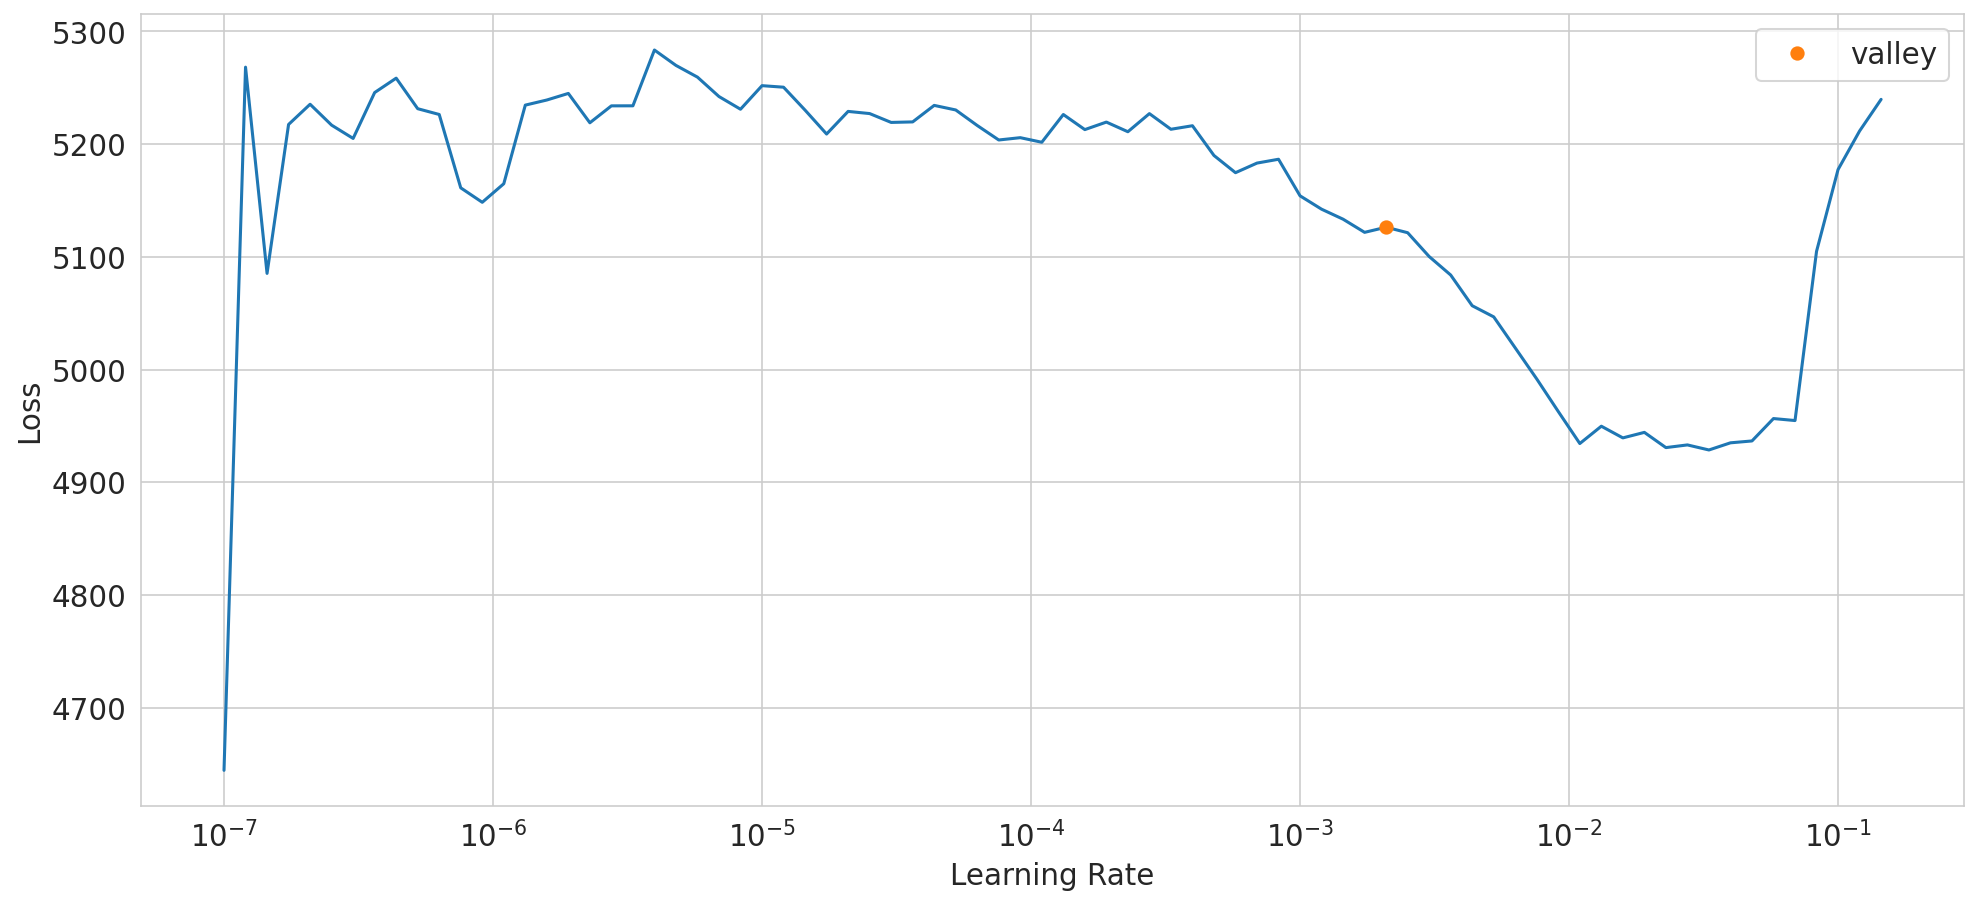

In [24]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

In [25]:
results.clear()  # reset results

dump model config

In [26]:
# needs class as argument, not instance, but serialization needs instance
analysis.params['last_decoder_activation'] = Sigmoid()

vaep.io.dump_json(
    vaep.io.parse_dict(
        analysis.params, types=[
            (torch.nn.modules.module.Module, lambda m: str(m))
        ]),
    args.out_models / TEMPLATE_MODEL_PARAMS.format(args.model_key))

# restore original value
analysis.params['last_decoder_activation'] = Sigmoid

In [27]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,5250.588379,311.816254,00:00
1,5217.283203,312.944580,00:00
2,5196.098145,314.846008,00:00
3,5174.083496,315.183990,00:00
4,5146.968262,316.751740,00:00
5,5120.504395,315.515747,00:00
6,5084.292480,311.334076,00:00
7,5049.763672,306.900421,00:00
8,5001.132812,300.480713,00:00
9,4946.462891,291.395630,00:00


No improvement since epoch 114: early stopping


Save number of actually trained epochs

In [28]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

165

#### Loss normalized by total number of measurements

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/vae_training


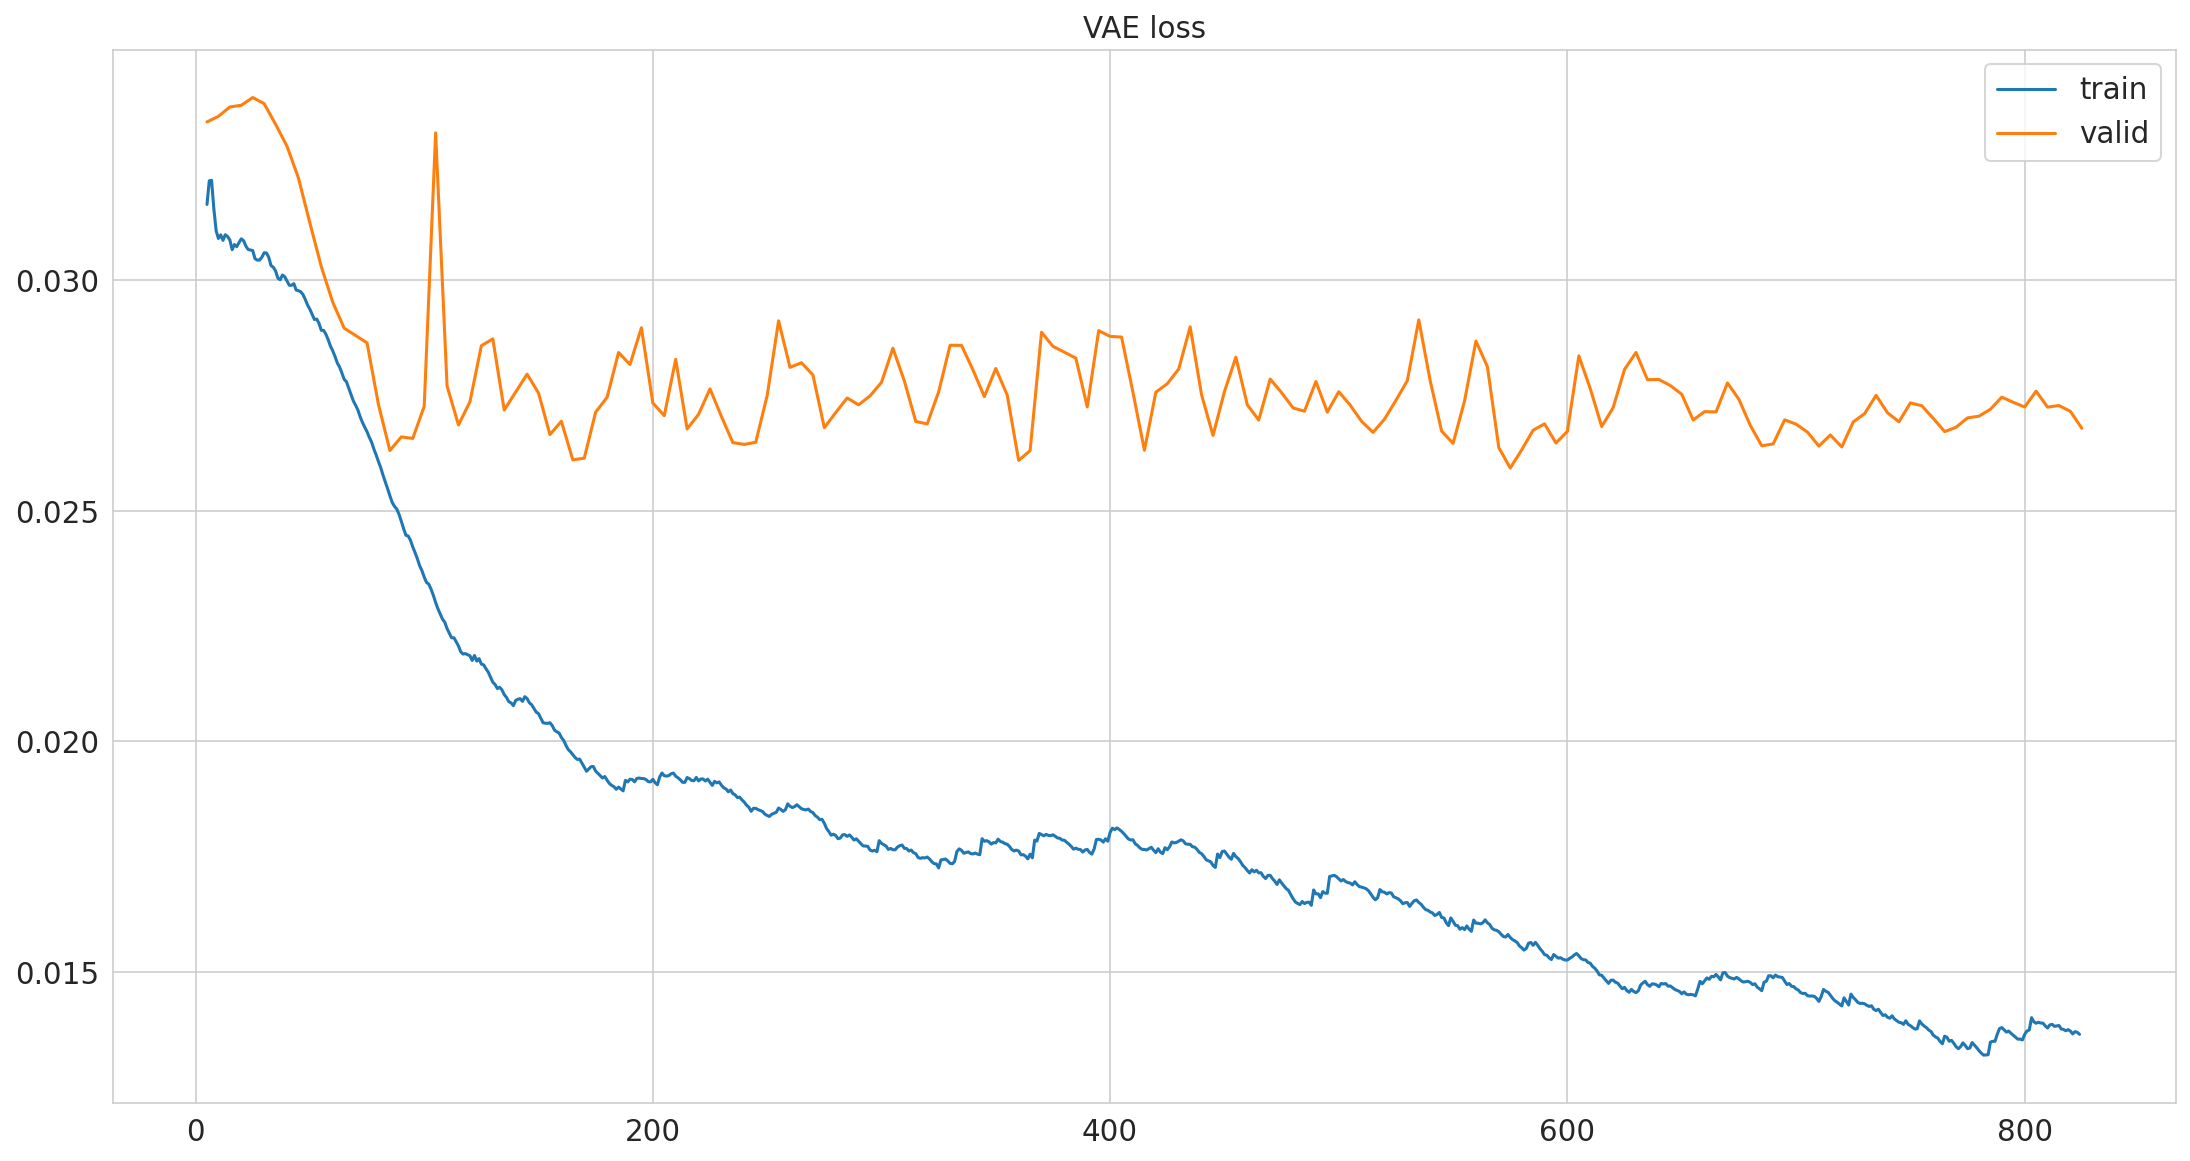

In [29]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

### Predictions
create predictions and select validation data predictions

In [30]:
analysis.model.eval()
pred, target = res = ae.get_preds_from_df(df=data.train_X, learn=analysis.learn,
                                          position_pred_tuple=0,
                                          transformer=analysis.transform)
pred = pred.stack()
pred

Sample ID                                       Gene Names      
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAAS               27.915
                                                AACS               25.599
                                                AAMDC              25.002
                                                AAMP               26.167
                                                AAR2               26.505
                                                                    ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ZWILCH             24.716
                                                ZWINT              26.026
                                                ZYX                29.939
                                                hCG_2014768;TMA7   28.687
                                                pk;ZAK             25.256
Length: 220250, dtype: float32

In [31]:
val_pred_simulated_na['VAE'] = pred  # 'model_key' ?
val_pred_simulated_na

,,observed,VAE
Sample ID,Gene Names,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,26.933
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,28.487
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,30.961
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,26.162
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,33.451
...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.256
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.119
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,24.514


In [32]:
test_pred_simulated_na['VAE'] = pred  # model_key?
test_pred_simulated_na

observed  \
Sample ID                                      Gene Names                   
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1               29.538   
                                               ACTN4               33.270   
                                               ADD3                24.259   
                                               ALCAM               24.906   
                                               ALDH1B1             26.674   
...                                                                   ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3               25.040   
                                               YTHDF3              28.717   
                                               ZC3H11A             28.935   
                                               ZFP91-CNTF;ZFP91    25.662   
                                               hCG_2014768;TMA7    29.212   

                                                                   VAE  
Sample ID                                      Gene Names               
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1            29.787  
                                               ACTN4            33.335  
                                               ADD3             25.268  
                                               ALCAM            24.908  
                                               ALDH1B1          26.809  
...                                                                ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3            25.970  
                                               YTHDF3           28.381  
                                               ZC3H11A          29.244  
                                               ZFP91-CNTF;ZFP91 26.771  
                                               hCG_2014768;TMA7 28.687  

[9327 rows x 2 columns]

save missing values predictions

In [33]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID                                       Gene Names 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070  AAMDC         25.002
                                                ABCB7         24.942
                                                ABCC4         23.283
                                                ABI2          25.227
                                                ACOT2;ACOT1   26.151
                                                               ...  
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070  ZNF346        25.371
                                                ZNF706        24.966
                                                ZNRF2         25.015
                                                ZWILCH        24.716
                                                pk;ZAK        25.256
Name: intensity, Length: 33698, dtype: float32

### Plots

- validation data

In [34]:
analysis.model = analysis.model.cpu()
# underlying data is train_X for both
# assert analysis.dls.valid.data.equals(analysis.dls.train.data)
# Reconstruct DataLoader for case that during training singleton batches were dropped
_dl = torch.utils.data.DataLoader(
    vaep.io.datasets.DatasetWithTarget(
        analysis.dls.valid.data),
    batch_size=args.batch_size,
    shuffle=False)
df_latent = vaep.model.get_latent_space(analysis.model.get_mu_and_logvar,
                                        dl=_dl,
                                        dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10,...,latent dimension 16,latent dimension 17,latent dimension 18,latent dimension 19,latent dimension 20,latent dimension 21,latent dimension 22,latent dimension 23,latent dimension 24,latent dimension 25
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,0.679,-0.588,-0.801,-1.773,-1.738,0.067,0.657,1.279,-1.210,-1.206,...,0.476,-0.481,-1.376,-1.308,-2.016,1.095,0.281,0.097,0.597,1.952
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,0.756,-1.269,0.411,-1.156,-1.184,0.257,0.312,1.741,-2.229,-0.938,...,0.327,-0.461,-0.576,-0.933,-1.328,1.619,0.086,-0.318,1.103,1.893
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,0.693,0.344,-1.614,-2.007,-1.757,0.158,0.928,0.440,-0.166,-1.491,...,0.446,-0.395,-1.669,-1.219,-2.214,0.413,0.404,0.340,0.135,1.643
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,0.771,-1.557,0.877,-0.720,-0.862,0.293,0.084,1.909,-2.474,-0.659,...,0.204,-0.374,-0.262,-0.672,-0.899,1.629,0.071,-0.510,1.176,1.666
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,1.280,1.856,0.436,-0.752,0.044,1.512,1.097,-1.655,0.494,-2.169,...,-0.152,-0.050,1.044,0.782,-0.989,0.057,-0.075,-0.503,1.240,0.129
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,1.274,2.031,-0.014,-0.954,0.109,1.547,1.158,-2.175,1.066,-2.090,...,0.026,-0.144,0.732,0.860,-0.920,-0.364,-0.013,-0.370,0.668,-0.213
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,-0.319,-0.304,3.089,3.589,1.853,0.276,-0.035,1.203,-1.441,0.669,...,-1.767,1.604,2.916,0.432,2.018,0.854,-0.481,-0.694,1.877,-1.378
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,-0.641,0.804,1.927,2.467,1.628,0.234,0.366,-0.541,0.059,0.464,...,-1.438,1.187,2.494,0.497,1.530,0.130,-0.657,-0.156,1.486,-1.355
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,1.593,1.271,1.152,-0.819,-0.422,1.464,0.988,-0.400,-0.930,-2.542,...,-0.248,-0.038,1.240,0.478,-1.445,1.121,-0.059,-0.773,2.215,1.078


In [35]:
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [36]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

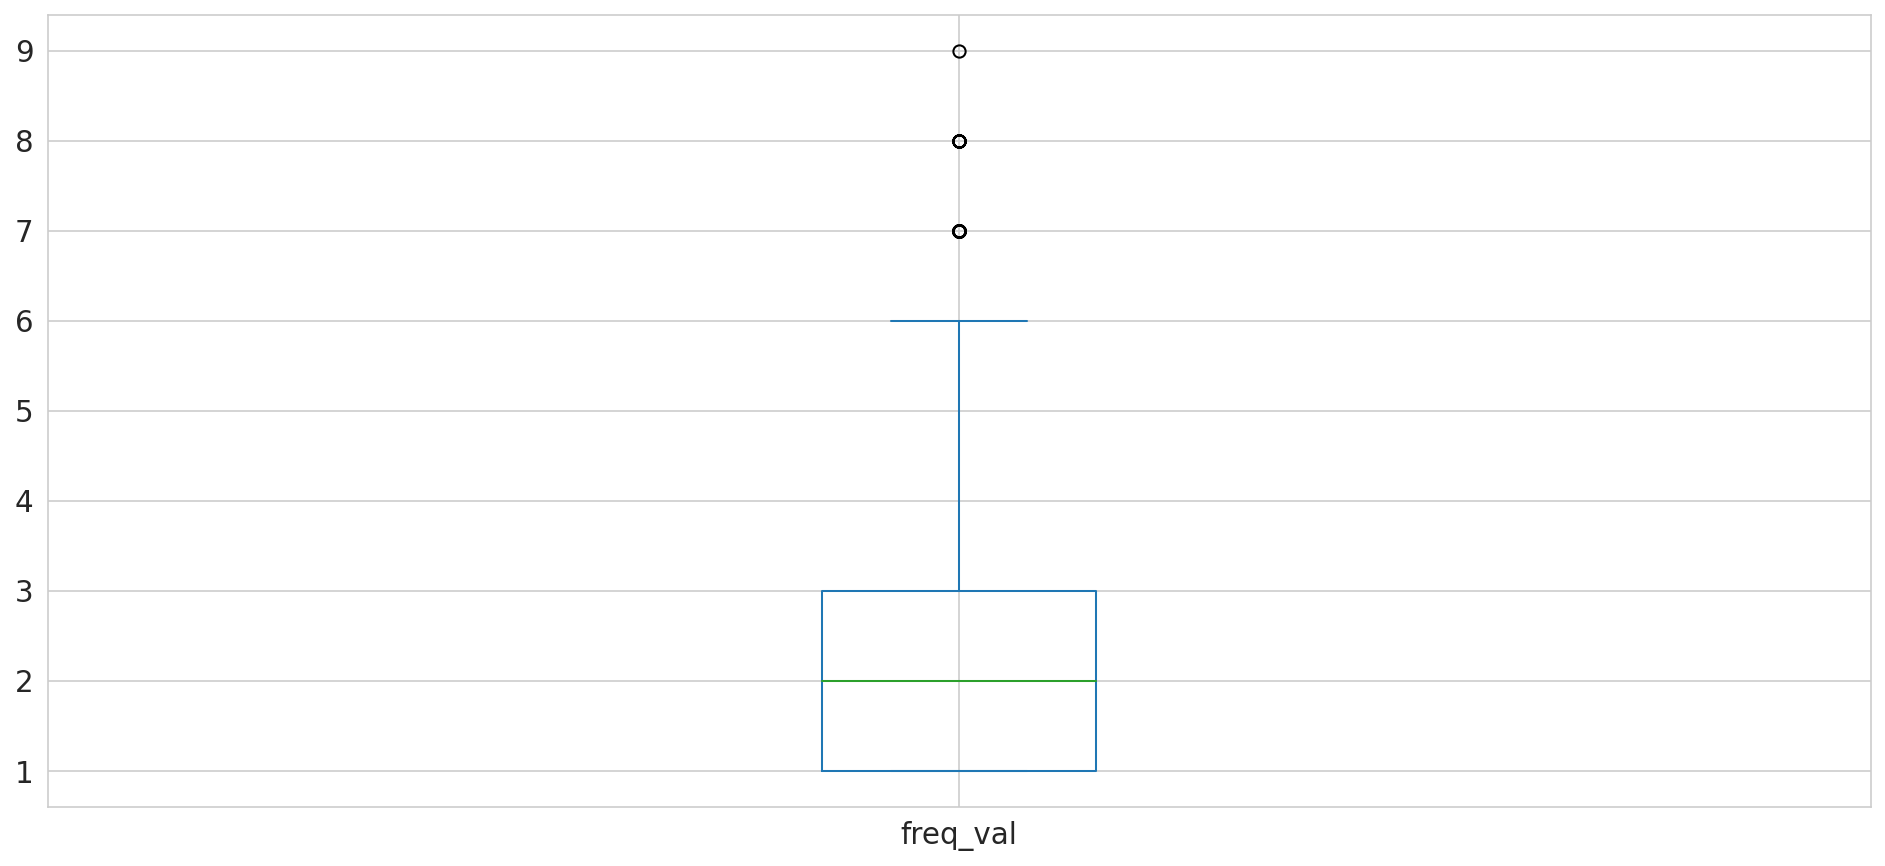

In [37]:
feat_freq_val = val_pred_simulated_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [38]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

freq_val
1   1,121
2   1,148
3     803
4     461
5     185
Name: count, dtype: int64

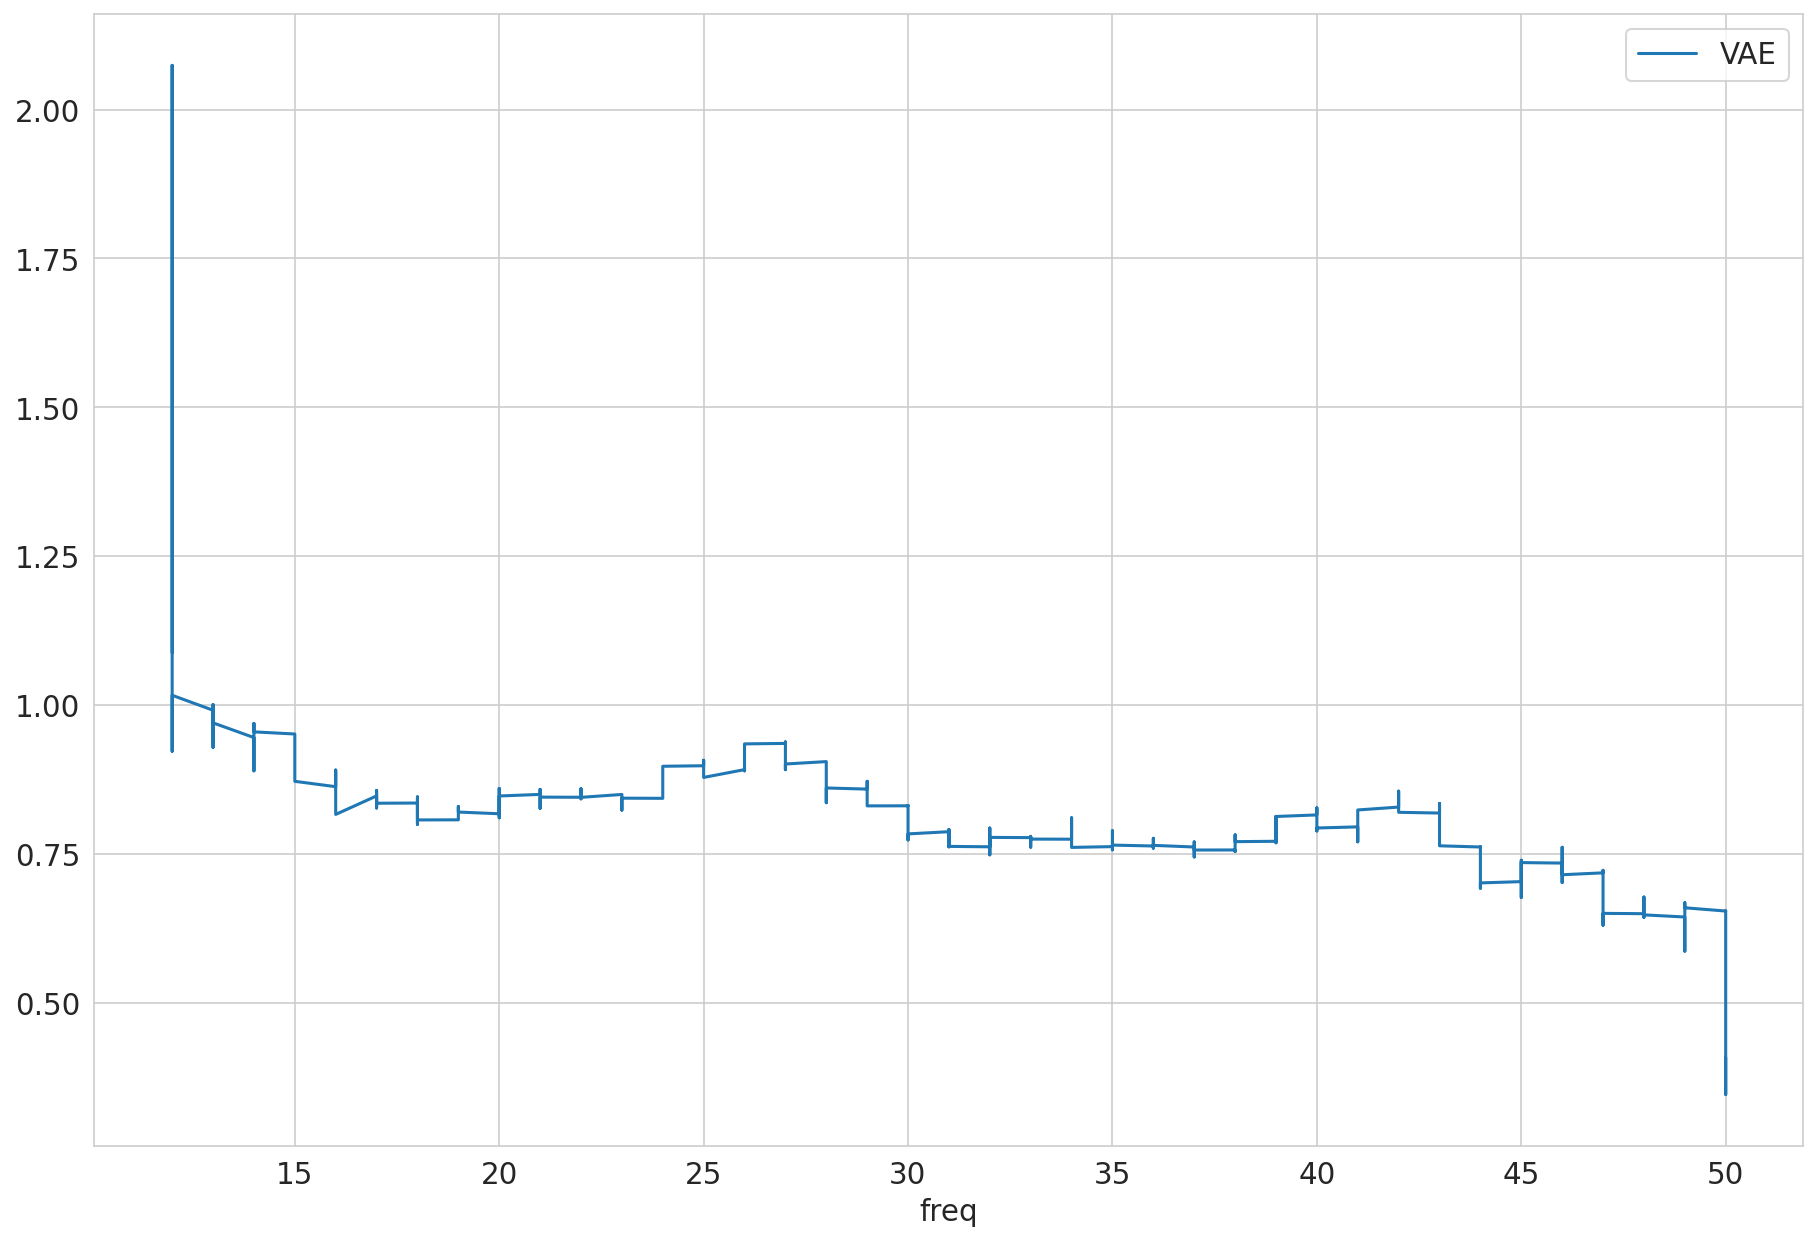

In [39]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-1]] = errors_val[errors_val.columns[:-1]
                                                          ].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [40]:
errors_val = val_pred_simulated_na.drop('observed', axis=1).sub(
    val_pred_simulated_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

VAE      
                  mean count
Gene Names                  
AAAS             1.406     2
AACS             1.639     2
AAMDC            0.465     5
AAMP             0.563     2
AAR2             0.647     2
...                ...   ...
ZWILCH           0.711     1
ZWINT            1.058     1
ZYX              0.537     4
hCG_2014768;TMA7 0.089     1
pk;ZAK           0.389     1

[3831 rows x 2 columns]

In [41]:
errors_val

,,VAE
Sample ID,Gene Names,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,-0.247
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,-1.772
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,0.332
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,1.620
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,-0.482
...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,-0.462
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,-0.848
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,-2.140


## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [42]:
# papermill_description=metrics
# d_metrics = models.Metrics(no_na_key='NA interpolated', with_na_key='NA not interpolated')
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [43]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 0.8656942710702494,
  'MAE': 0.6345573334314721,
  'N': 9327,
  'prop': 1.0}}

### Test Datasplit


In [44]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'VAE': {'MSE': 0.8865745317463823,
  'MAE': 0.6362582298798918,
  'N': 9327,
  'prop': 1.0}}

Save all metrics as json

In [45]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics /
                  f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'VAE': { 'MAE': 0.6362582298798918,
                                  'MSE': 0.8865745317463823,
                                  'N': 9327,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'VAE': { 'MAE': 0.6345573334314721,
                                   'MSE': 0.8656942710702494,
                                   'N': 9327,
                                   'prop': 1.0}}}

In [46]:
metrics_df = models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
VAE   MSE                       0.866              0.887
      MAE                       0.635              0.636
      N                     9,327.000          9,327.000
      prop                      1.000              1.000

## Save predictions

In [47]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [48]:
figures  # switch to fnames?

{}

In [49]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 4405,
 'batch_size': 10,
 'cuda': False,
 'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'epoch_trained': 165,
 'epochs_max': 200,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'hidden_layers': [512, 256],
 'latent_dim': 25,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'VAE',
 'model_key': 'VAE',
 'n_params': 7060892,
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'patience': 50,
 'sample_idx_position': 0,
 'save_pred_real_na': True}